# 🔂프로젝트: 한영 번역기 만들기
---
### Step 1. 데이터 다운로드
### Step 2. 데이터 정제
### Step 3. 데이터 토큰화
### Step 4. 모델 설계
### Step 5. 훈련하기

### 루브릭
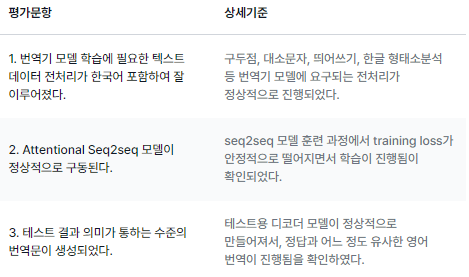

**준비해봅시다!**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.6.0


## Step 1. 데이터 다운로드 및 로드

In [3]:
import os
import tarfile

# 이미 다운로드된 korean-english-park.train.tar.gz 파일의 경로를 지정합니다.
path_to_zip = 'korean-english-park.train.tar.gz'

# 압축을 풀 폴더 경로를 지정합니다.
extract_path = os.path.dirname(path_to_zip) + "/korean-english-park"

# tar.gz 파일을 압축 해제합니다.
with tarfile.open(path_to_zip, 'r:gz') as tar:
    tar.extractall(path=extract_path)

# 압축 해제된 파일 경로를 확인
path_to_file = extract_path + "/korean-english-park.train"
print(f"Extracted file path: {path_to_file}")


Extracted file path: /korean-english-park/korean-english-park.train


In [4]:
import os

# 파일 경로 설정 (디렉토리 내 파일들)
path_to_dir = '/aiffel/aiffel/Aiffel_quest_rs/GoingDeeper/Gd04/korean-english-park'

# 영어 파일 경로와 한글 파일 경로 설정
en_file = os.path.join(path_to_dir, 'korean-english-park.train.en')
ko_file = os.path.join(path_to_dir, 'korean-english-park.train.ko')

# 영어 파일 읽기
with open(en_file, "r", encoding="utf-8") as f_en:
    en_sentences = f_en.read().splitlines()

# 한글 파일 읽기
with open(ko_file, "r", encoding="utf-8") as f_ko:
    ko_sentences = f_ko.read().splitlines()

# 데이터 크기 확인
print("English Data Size:", len(en_sentences))
print("Korean Data Size:", len(ko_sentences))

# 예시 출력 (영어와 한글 병렬로 확인)
print("\nExample Sentences:")
for en_sen, ko_sen in zip(en_sentences[0:100][::20], ko_sentences[0:100][::20]):
    print("English: ", en_sen)
    print("Korean : ", ko_sen)
    print()


English Data Size: 94123
Korean Data Size: 94123

Example Sentences:
English:  Much of personal computing is about "can you top this?"
Korean :  개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"

English:  Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
Korean :  북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.

English:  “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
Korean :  "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."

English:  Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
Korean :  수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.

English:  Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they 

데이터를 쌍으로 묶어서 저장하기

In [5]:
import os

# 파일 경로 설정 (korean-english-park.train.en와 korean-english-park.train.ko 파일 경로)
path_to_eng = '/aiffel/aiffel/Aiffel_quest_rs/GoingDeeper/Gd04/korean-english-park/korean-english-park.train.en'
path_to_kor = '/aiffel/aiffel/Aiffel_quest_rs/GoingDeeper/Gd04/korean-english-park/korean-english-park.train.ko'

# 두 파일에서 데이터를 읽어와 raw 데이터로 생성
with open(path_to_eng, "r", encoding="utf-8") as eng_file, \
     open(path_to_kor, "r", encoding="utf-8") as kor_file:
    
    eng_data = eng_file.read().splitlines()
    kor_data = kor_file.read().splitlines()

# 두 데이터를 한 줄씩 쌍(pair)으로 묶어서 raw 리스트에 저장
raw = [f"{eng}\t{kor}" for eng, kor in zip(eng_data, kor_data)]

print(f"Data Size: {len(raw)}")
print("Example Pairs:")
for sen in raw[:5]:  # 5개의 예시 데이터 출력
    print(sen)


Data Size: 94123
Example Pairs:
Much of personal computing is about "can you top this?"	개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.	모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
Like all optical mice, But it also doesn't need a desk.	그러나 이것은 또한 책상도 필요로 하지 않는다.
uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.	79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.	정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.


1. 영어 파일과 한글 파일 경로 설정: os.path.join()을 사용해 korean-english-park.train.en와 korean-english-park.train.ko 두 파일의 경로를 각각 설정
2. 파일 읽기: 영어와 한글 파일을 각각 열어서 .splitlines()를 통해 각 줄을 하나의 리스트 항목으로 변환
3. 병렬 데이터 확인: 영어와 한글 데이터를 나란히 출력하여 번역 데이터의 형태를 확인

## Step 2. 데이터 정제
1. `set` 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 `<start>` 토큰과 `<end>` 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. `cleaned_corpus`로부터 토큰의 길이가 `40` 이하인 데이터를 선별하여 `eng_corpus`와 `kor_corpus`를 각각 구축하세요.

중복된 데이터를 제거 해봅시다!(`set`데이터형 사용)

In [6]:
# Step 1: 중복 데이터 제거
cleaned_corpus = set()

num_examples = 50000  # 사용할 데이터 수 제한
enc_corpus = []
dec_corpus = []

for pair in raw[:num_examples]:
    eng, kor = pair.split("\t")
    
    # 중복되지 않는 데이터만 set에 추가
    if (eng, kor) not in cleaned_corpus:
        cleaned_corpus.add((eng, kor))
        enc_corpus.append(eng)
        dec_corpus.append(kor)

print("Total Unique Pairs:", len(enc_corpus))


Total Unique Pairs: 49639


한글과 영어 전처리 함수 재정의를 해봅시다!

In [7]:
import re
from konlpy.tag import Mecab

# Mecab 초기화
mecab = Mecab()

# Step 2: 한글과 영어 전처리 함수 정의
def preprocess_sentence(sentence, s_token=False, e_token=False, lang="eng"):
    sentence = sentence.lower().strip()
         
    # 영어 전처리
    if lang == "eng":
        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()

        if s_token:
            sentence = '<start> ' + sentence
        if e_token:
            sentence += ' <end>'
    
    # 한글 전처리
    elif lang == "kor":
        sentence = sentence.strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)  # 한글, 숫자, 특수문자만 남김
        sentence = ' '.join(mecab.morphs(sentence))  # Mecab을 이용한 토큰화

        # 한글 문장에도 <start>와 <end> 토큰을 추가
        if s_token:
            sentence = '<start> ' + sentence
        if e_token:
            sentence += ' <end>'
    
    return sentence



영어와 한글 코퍼스를 생성
- 영문: `<start>`, `<end>` 토큰추가
- 한글: mecab 토큰화

In [8]:
# Step 3: 영어와 한글의 코퍼스 생성
enc_corpus = []
dec_corpus = []

for pair in raw[:num_examples]:
    eng, kor = pair.split("\t")

    eng_sentence = preprocess_sentence(eng, s_token=True, e_token=True, lang="eng")
    kor_sentence = preprocess_sentence(kor, s_token=True, e_token=True, lang="kor")

    if (eng_sentence, kor_sentence) not in cleaned_corpus:
        cleaned_corpus.add((eng_sentence, kor_sentence))
        enc_corpus.append(eng_sentence)
        dec_corpus.append(kor_sentence)

print("총 두 언어의 고유 쌍 개수:", len(enc_corpus))


총 두 언어의 고유 쌍 개수: 49615


토큰 길이가 40 이하인 데이터를 선별해보자!

In [9]:
eng_corpus = []
kor_corpus = []

for eng_sentence, kor_sentence in zip(enc_corpus, dec_corpus):
    
    eng_sentence = preprocess_sentence(eng, s_token=True, e_token=True, lang="eng")
    kor_sentence = preprocess_sentence(kor, s_token=True, e_token=True, lang="kor")
    
    if len(eng_sentence.split()) <= 40 and len(kor_sentence.split()) <= 40:
        eng_corpus.append(eng_sentence)
        kor_corpus.append(kor_sentence)

print("필터링된 영어 문장:", len(eng_corpus))
print("필터링된 한글 문장:", len(kor_corpus))

# 예시 출력
print("\n예시 문장:")
for eng_sen, kor_sen in zip(eng_corpus[0:5], kor_corpus[0:5]):
    print("English: ", eng_sen)
    print("Korean : ", kor_sen)
    print()

필터링된 영어 문장: 36795
필터링된 한글 문장: 36795

예시 문장:
English:  <start> much of personal computing is about can you top this ? <end>
Korean :  <start> 개인 용 컴퓨터 사용 의 상당 부분 은 이것 보다 뛰어날 수 있 느냐 ? <end>

English:  <start> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse . <end>
Korean :  <start> 모든 광 마우스 와 마찬가지 로 이 광 마우스 도 책상 위 에 놓 는 마우스 패드 를 필요 로 하 지 않 는다 . <end>

English:  <start> like all optical mice , but it also doesn t need a desk . <end>
Korean :  <start> 그러나 이것 은 또한 책상 도 필요 로 하 지 않 는다 . <end>

English:  <start> something that will boost their capabilities at crucial moments is very important . <end>
Korean :  <start> 결정 적 인 순간 에 그 들 의 능력 을 증가 시켜 줄 그 무엇 이 매우 중요 합니다 . <end>

English:  <start> researchers are already exploring ways to put caffeine in nutrition bars or chewing gum as alternatives to coffee , archibald said . <end>
Korean :  <start> 연구가 들 이 이미 커피 대체 품 으로서 음식 대용 과자 나 껌 에 카페인 을 첨가 하 는 방법 을 연구 하 고 있 다고 는 말 했 다 

## Step 3. 데이터 토큰화
`tokenize()` 함수를 사용해 데이터를 텐서로 변환하기

In [10]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [11]:
# 주어진 corpus 리스트를 tokenize() 함수로 텐서로 변환
def preprocess_and_tokenize(enc_corpus, dec_corpus):
    enc_tensor, enc_tokenizer = tokenize(enc_corpus)  # 영어 문장 토큰화
    dec_tensor, dec_tokenizer = tokenize(dec_corpus)  # 한글 문장 토큰화

    return enc_tensor, dec_tensor, enc_tokenizer, dec_tokenizer

# 데이터 토큰화 및 텐서 변환
enc_tensor, dec_tensor, enc_tokenizer, dec_tokenizer = preprocess_and_tokenize(eng_corpus, kor_corpus)

print(f'전체 샘플 수: {len(enc_tensor)}')

전체 샘플 수: 36795


In [12]:
print(f"<start> token index: {dec_tokenizer.word_index.get('<start>', 'Not Found')}")
print(f"<end> token index: {dec_tokenizer.word_index.get('<end>', 'Not Found')}")


<start> token index: 2
<end> token index: 3


## Step4. 모델 설계
- Attention 기반 Seq2Seq 모델을 설계합니다.
- `Dropout`모듈과 `Embedding Size`와 `Hidden Size` 값을 맞춰주도록 합니다

실습해서 했던 `Attention Bahdanau` 를 사용합니다!

- GRU 구조
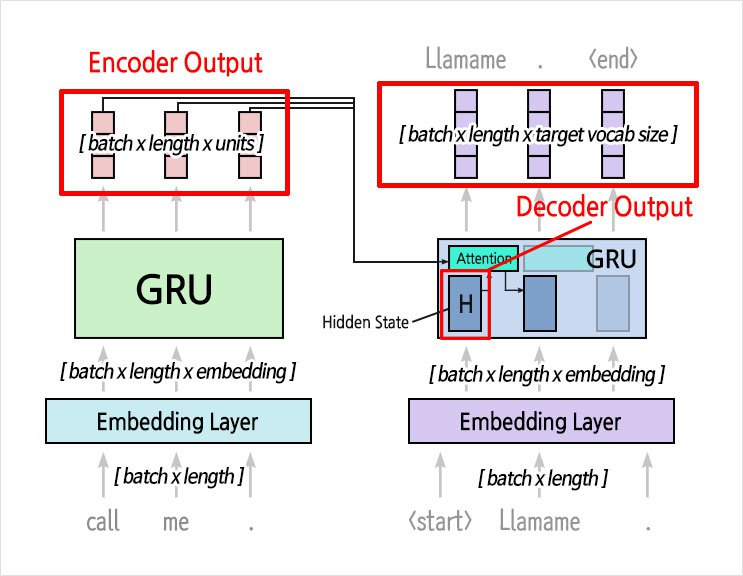


In [13]:
# `Attention Bahdanau` 를 사용
# 근데 DropOut을 곁들인.
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.3):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)  # Dropout 추가

    def call(self, h_enc, h_dec, training=True):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        # 인코더 출력을 Dense에 적용 후 Dropout 수행
        h_enc = self.w_enc(h_enc)
        h_enc = self.dropout(h_enc, training=training)  # Dropout 적용

        # 디코더 출력을 Dense에 적용 후 Dropout 수행
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        h_dec = self.dropout(h_dec, training=training)  # Dropout 적용

        # attention score 계산
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # softmax 적용
        attn = tf.nn.softmax(score, axis=1)

        # context vector 계산
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


인코더 구조

In [14]:
# 인코더 클래스
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_rate=0.3):
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size  # Hidden Size로 명칭 통일
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(hidden_size, return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training=False):
        out = self.embedding(x)
        out = self.dropout(out, training=training)  # Embedding 출력에 Dropout 적용
        out = self.gru(out)
        out = self.dropout(out, training=training)  # GRU 출력에 Dropout 적용
        
        return out


디코더 구조

In [15]:
# 디코더 클래스
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size  # Hidden Size로 명칭 통일
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(hidden_size, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.hidden_size)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)  # Dropout 추가

    def call(self, x, h_dec, enc_out, training=False):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        out = self.dropout(out, training=training)
        out, h_dec = self.gru(out)
        out = self.dropout(out, training=training)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn


In [16]:
# 하이퍼파라미터 설정
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

hidden_size    = 1024  # Hidden size (GRU units)
embedding_dim  = 1024  # Embedding size

# 인코더 및 디코더 초기화
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, hidden_size)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, hidden_size)

# sample input
sequence_len = 30  # 샘플 입력 시퀀스 길이

# 샘플 인코더 입력 (랜덤 데이터)
sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))

# 인코더 출력 실행
sample_output = encoder(sample_enc)

# 인코더 출력 결과 확인
print('Encoder Output:', sample_output.shape)

# 샘플 디코더 입력 상태 (랜덤 데이터)
sample_state = tf.random.uniform((BATCH_SIZE, hidden_size))

# 디코더 출력 실행
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

# 디코더 출력 결과 확인
print('Decoder Output:', sample_logits.shape)
print('Decoder Hidden State:', h_dec.shape)
print('Attention:', attn.shape)


Encoder Output: (32, 30, 1024)
Decoder Output: (32, 31301)
Decoder Hidden State: (32, 1024)
Attention: (32, 30, 1)


## Step 5. 훈련하기
- Optimizer & Loss

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

여기서 fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문

Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야함

SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해야함

from_logits 는 확률 분포가 softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지 결정.

train_step 구현

In [18]:
@tf.function
def train_step(enc_input, dec_input, encoder, decoder, optimizer, dec_tokenizer):
    bsz = enc_input.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        # 인코더 실행
        enc_output = encoder(enc_input)
        dec_hidden = enc_output[:, -1]

        # 디코더 입력 설정
        dec_input_seq = tf.expand_dims([dec_tokenizer.word_index['<start>']] * bsz, 1)

        # 디코더를 단계별로 실행
        for t in range(1, dec_input.shape[1]):
            # 예측
            pred, dec_hidden, _ = decoder(dec_input_seq, dec_hidden, enc_output)

            # 손실 계산
            loss += loss_function(dec_input[:, t], pred)

            # 다음 입력을 설정
            dec_input_seq = tf.expand_dims(dec_input[:, t], 1)

    # 배치 손실 계산
    batch_loss = loss / int(dec_input.shape[1])

    # 기울기 계산 및 적용
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [19]:
# translate 함수에서 첫 번째 입력이 제대로 들어가고 있는지 확인
dec_input_seq = tf.expand_dims([dec_tokenizer.word_index['<start>']], 1)  # <start> 토큰으로 시작

@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 

첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함

- tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프

### train_step()의 학습 과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 <start> 토큰 문장 생성
4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

훈련 시작하기!

In [20]:
BATCH_SIZE = 32
BUFFER_SIZE = len(enc_tensor)
steps_per_epoch = len(enc_tensor) // BATCH_SIZE

# tf.data를 사용하여 배치 데이터를 만들기
dataset = tf.data.Dataset.from_tensor_slices((enc_tensor, dec_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# 데이터셋의 크기 확인
for enc, dec in dataset.take(1):
    print(enc.shape, dec.shape)  # 예: (64, max_len)

(32, 40) (32, 40)


### 오류!
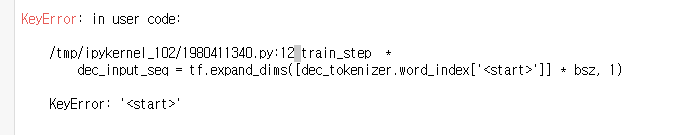

처음에 Step3에서 조건을 보고
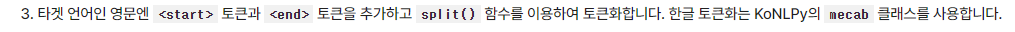
이 문장을 참고해서 한글에는 `<start>`, `<end>` 토큰을 넣지 않았는데. 
    
후에 학습을 하려니깐 첫번째 이미지처럼 오류가 발생했다.
    
**mecab을 사용하더라도 두 토큰을 추가해야 문장을 처리할 수 있다** 고 찾아보고 확인했기에 다시 수정하고 돌렸다.
    
#### 해결
    
```
        # 한글 문장에도 <start>와 <end> 토큰을 추가
        if s_token:
            sentence = '<start> ' + sentence
        if e_token:
            sentence += ' <end>'
```
토큰을 추가하고, KOR 코퍼스에 `s_token=True, e_token=True`을 추가

In [22]:
from tqdm import tqdm
import random

EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    t = tqdm(dataset)  # 배치 단위로 데이터셋에서 가져오기

    for (batch, (enc_batch, dec_batch)) in enumerate(t):
        # train_step 함수 호출 (앞서 정의한 train_step 함수 사용)
        batch_loss = train_step(enc_batch, dec_batch, encoder, decoder, optimizer, dec_tokenizer)
        
        # 손실 합계 계산
        total_loss += batch_loss
        
        # 진행 상황 및 손실 표시
        t.set_description_str(f'Epoch {epoch + 1}')
        t.set_postfix_str(f'Loss {total_loss.numpy() / (batch + 1):.4f}')


Epoch 3: 100%|██████████| 1149/1149 [07:53<00:00,  2.42it/s, Loss 4.8932]


In [23]:
# 예문을 토큰화하여 모델에 입력할 수 있도록 준비
example_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

# 전처리 및 토큰화
preprocessed_examples = [preprocess_sentence(sentence, s_token=True, e_token=True, lang='kor') for sentence in example_sentences]

# 각 문장을 토큰화된 텐서로 변환
example_tensor, _ = tokenize(preprocessed_examples)

# 예문에 대한 번역 생성 함수
def translate(sentence_tensor, encoder, decoder, dec_tokenizer, max_length=50):
    result = []
    
    # 인코더로 입력 문장 처리
    enc_output = encoder(sentence_tensor)
    dec_hidden = enc_output[:, -1]

    # 디코더의 첫 번째 입력: <start> 토큰
    dec_input_seq = tf.expand_dims([dec_tokenizer.word_index['<start>']], 1)
    
    for t in range(max_length):
        # 디코더 예측
        pred, dec_hidden, _ = decoder(dec_input_seq, dec_hidden, enc_output)
        
        # 예측된 단어 인덱스
        pred_id = tf.argmax(pred[0]).numpy()
        pred_word = dec_tokenizer.index_word.get(pred_id, '')

        # 예측 결과 출력 (디버깅용)
        print(f"Step {t+1}, Predicted ID: {pred_id}, Word: {pred_word}")
        
        # <end> 토큰을 만나면 번역 완료
        if pred_word == '<end>':
            break
        
        # 예측된 단어를 결과에 추가
        result.append(pred_word)
        
        # 예측된 단어를 디코더의 다음 입력으로 설정
        dec_input_seq = tf.expand_dims([pred_id], 1)
    
    return ' '.join(result)


# 각 예문에 대한 번역 생성 및 출력
for i, example in enumerate(example_tensor):
    translation = translate(tf.expand_dims(example, 0), encoder, decoder, dec_tokenizer)
    print(f"Example {i+1}: {translation} <end>")


Step 1, Predicted ID: 4, Word: 다
Step 2, Predicted ID: 4, Word: 다
Step 3, Predicted ID: 4, Word: 다
Step 4, Predicted ID: 4, Word: 다
Step 5, Predicted ID: 4, Word: 다
Step 6, Predicted ID: 4, Word: 다
Step 7, Predicted ID: 4, Word: 다
Step 8, Predicted ID: 4, Word: 다
Step 9, Predicted ID: 4, Word: 다
Step 10, Predicted ID: 4, Word: 다
Step 11, Predicted ID: 4, Word: 다
Step 12, Predicted ID: 4, Word: 다
Step 13, Predicted ID: 4, Word: 다
Step 14, Predicted ID: 4, Word: 다
Step 15, Predicted ID: 4, Word: 다
Step 16, Predicted ID: 4, Word: 다
Step 17, Predicted ID: 4, Word: 다
Step 18, Predicted ID: 4, Word: 다
Step 19, Predicted ID: 4, Word: 다
Step 20, Predicted ID: 4, Word: 다
Step 21, Predicted ID: 4, Word: 다
Step 22, Predicted ID: 4, Word: 다
Step 23, Predicted ID: 4, Word: 다
Step 24, Predicted ID: 4, Word: 다
Step 25, Predicted ID: 4, Word: 다
Step 26, Predicted ID: 4, Word: 다
Step 27, Predicted ID: 4, Word: 다
Step 28, Predicted ID: 4, Word: 다
Step 29, Predicted ID: 4, Word: 다
Step 30, Predicted ID: 

아무리 파라미터, 구조를 바꿔봐도 성능이 잘 나오지 않는다..

더 실험해보고 수정해봐서 성능을 개선해나갈 예정이다.

### Attention Map 출력

Input: can i have some coffee ?
Predicted translation: 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 다 


/tmp/ipykernel_425/1863201069.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_425/1863201069.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


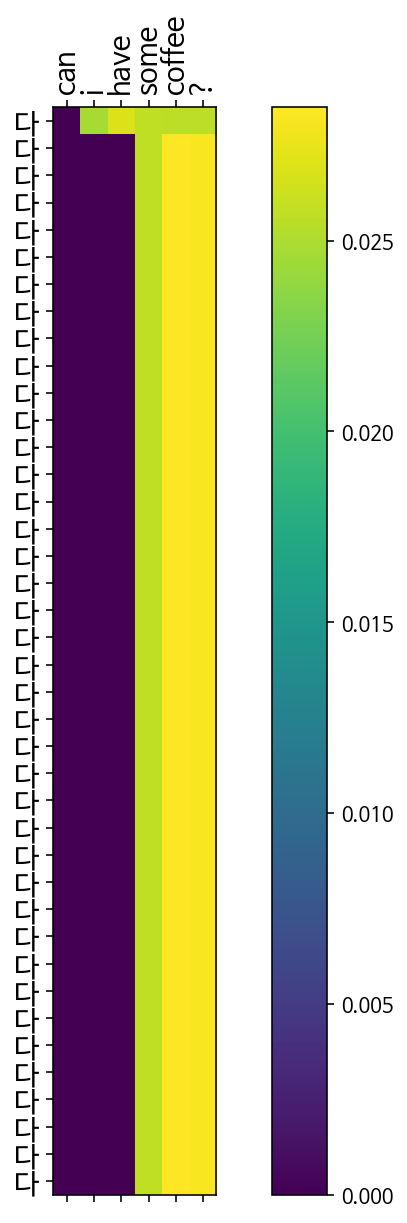

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def translate_and_plot_attention(sentence, encoder, decoder):
    attention = np.zeros((dec_batch.shape[-1], enc_batch.shape[-1]))
    
    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_batch.shape[-1],
                                                           padding='post')

    result = ''

    # 인코더 실행
    enc_out = encoder(inputs)

    # 디코더 첫 입력은 <start> 토큰
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_batch.shape[-1]):
        # 디코더 실행
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        # 가장 높은 확률의 단어 선택
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        # 예측된 단어가 <end>이면 번역 종료
        if dec_tokenizer.index_word[predicted_id] == '<end>':
            break

        # 다음 디코더 입력으로 현재 예측된 단어를 넣음
        dec_input = tf.expand_dims([predicted_id], 0)

    # 번역 결과 출력
    print('Input: %s' % sentence)
    print('Predicted translation: %s' % result)

    # Attention Map 출력
    plot_attention(attention[:len(result.split()), :len(sentence.split())], sentence.split(), result.split(' '))

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention, cmap='viridis')

    fig.colorbar(cax)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# 예시 문장 번역 및 Attention Map 출력
translate_and_plot_attention("Can I have some coffee?", encoder, decoder)


### 번역기 챗봇

In [ ]:
import tensorflow as tf

# 사용자로부터 입력을 받고 번역을 생성하는 함수
def translate_sentence(input_sentence, encoder, decoder, dec_tokenizer, max_length=50):
    # 입력 문장 전처리
    preprocessed_input = preprocess_sentence(input_sentence, s_token=True, e_token=True, lang='kor')
    
    # 입력 문장을 텐서로 변환
    input_tensor, _ = tokenize([preprocessed_input])
    
    # 번역 생성
    translation = translate(tf.expand_dims(input_tensor[0], 0), encoder, decoder, dec_tokenizer, max_length)
    
    return translation

def chat():
    print("한영 번역기입니다. '종료'라고 입력하면 프로그램이 종료됩니다.")
    while True:
        # 사용자 입력
        input_sentence = input("번역할 한국어 문장을 입력하세요: ")

        # '종료'를 입력하면 프로그램 종료
        if input_sentence.lower() == "종료":
            print("번역기를 종료합니다.")
            break
        
        # 번역 생성
        translation = translate_sentence(input_sentence, encoder, decoder, dec_tokenizer)
        
        # 번역 결과 출력
        print(f"번역: {translation} <end>\n")

# 실제로 번역을 생성하는 translate 함수 (위에서 사용한 함수)
def translate(sentence_tensor, encoder, decoder, dec_tokenizer, max_length=50):
    result = []
    
    # 인코더로 입력 문장 처리
    enc_output = encoder(sentence_tensor)
    dec_hidden = enc_output[:, -1]

    # 디코더의 첫 번째 입력: <start> 토큰
    dec_input_seq = tf.expand_dims([dec_tokenizer.word_index['<start>']], 1)
    
    for t in range(max_length):
        # 디코더 예측
        pred, dec_hidden, _ = decoder(dec_input_seq, dec_hidden, enc_output)
        
        # 예측된 단어 인덱스
        pred_id = tf.argmax(pred[0]).numpy()
        
        # <end> 토큰을 만나면 번역 완료
        if dec_tokenizer.index_word[pred_id] == '<end>':
            break
        
        # 예측된 단어를 결과에 추가
        result.append(dec_tokenizer.index_word[pred_id])
        
        # 예측된 단어를 디코더의 다음 입력으로 설정
        dec_input_seq = tf.expand_dims([pred_id], 1)
    
    return ' '.join(result)

# 실제로 챗봇을 실행하는 코드
chat()


## 회고
seq2seq 모델을 가지고 한글-영어 번역기를 만들어보는데, 참 성능 높이기가 어려웠던 것 같다. 지금은 주어진 데이터셋으로 해보고 있지만, 데이터에 따라 성능이 달라진다고 하니깐 다른 데이터로 적용해서 구현해보고 싶다는 생각이 들었다. 그래도 계속 모델의 아키텍처를 분석해서 알게되고, 구현할 때 왜 이 부분을 구현해야하는지 점점 이해하게 되어서 좋은 것 같다. 에러와 열심히 싸우고 성능 높이기에 싸웠지만, 그것조차 경험과 성장이라고 본다! 열심히해야지:) 